In [1]:
import warnings # Will be used to ignore the unnecessary warning so that the code look good esthetically
warnings.filterwarnings('ignore')

In [2]:
# import required libraries
%matplotlib inline
from scipy.interpolate import CubicSpline  # For  interpolation functions
import matplotlib.pyplot as plt
import seismic.additional_functions as seis # library created for the purpose of this lecture series, explore further if interested!
import numpy as np
#import segyio
import os

## Practical 2 - CMP gathers, NMO corrections and semblance velocity analysis

In this exercise we will view firstly a synthetic CMP gather and then a real CMP gather and conduct an NMO correction. By working through the exercise you will learn how to conduct semblance analysis to determine the correct velocity profile to use for NMO corrections of a full seismic trace. As you work on the exercise think about how data science and artificial intelligence may be able to improve on these standard workflows.

**Learning Objectives**:
1)	Understand gathers and their physical components
2)	Understand how pre-stack datasets are formatted and how to view them
3)	Understand how and why we need to do NMO corrections


## 2.1 Manual calculation


## Reminder from lecture

- Each reflection event in a CMP gather has a travel time that corresponds to a hyperbola: 

$$t ^{2} = t_0 ^{2} + x ^{2}v^2_{stacking}$$


where $x$ is offset between source and receiver, $v_{stacking}$ is stacking velocity, and $t_0$ is the intercept time: 

$$ t_0 = \sqrt{\frac{4d^2}{v^2_{stacking}}}$$

where $d$ is the thickness of the first layer.

- For each reflection event hyperbola, perform a velocity analysis to find $v_{stacking}$. This is done by first choosing $t_o$. Then choose a trial value of velocity. <img src="http://www.eos.ubc.ca/courses/eosc350/content/methods/meth_10d/assets/kearey_fig4_21.gif"></img>

- Calculate the Normal Moveout Correction: Using the hyperbolia corresponding to $v_{stacking}$, compute the normal moveout for each trace and then adjust the reflection time by the amount $\triangle T$: $$ \triangle T = t_0-t(x) \\ $$ <img src="http://www.eos.ubc.ca/courses/eosc350/content/methods/meth_10d/assets/ch1_fig8.gif"></img>

Estimate $t_0$, and a plausible $v_{stack}$ by altering t0 and v using below widget. This hyperbola will be drawn as red hyperbola on the middle panel. On the right panel we apply stack with the velocity that you fit, and provice stacked trace.

## <code style="background:yellow;color:black"> <font color='green'> **See [example](./EX12.ipynb)  that shows how to implement NMO correction for analytically defined seismic data and display the results in a color plot using Python.**</font> </.</code>


## 2.1.2 Conducting the NMO correction with prescribed velocities


**QUESTION: You are provided with an example of a typical CMP gather (Records 7). All sources and receivers can be assumed to be at the Earth’s surface. Record 7 shows a land record in which the source was dynamite. This gather contains 96 traces with a 25 m trace spacing.**

![NMO](data/NMO.png)




**1) Calculate the NMO velocities of reflections A and B**

reflection A:
- at x = 0, t = 0.66s
- Note that there are 86 traces in the CMP, but the x_0 position is offset from the centre!
- at x = 70 traces x 25 m spacing = 1750 m, t_x = 1.0s

$$t ^{2} = t_0 ^{2} + x ^{2} V_s ^{2}$$

$$1 ^{2} = 0.66 ^{2} + 17502 V_{RMS} ^{2}$$

$$V_{RMS} = 2330 m/s$$


reflection B:
- at x = 0, t = 2.0s
- Note that there are 86 traces in the CMP, but the x_0 position is offset from the centre!
- at x = 70 traces x 25 m spacing = 1750 m, t_x = 2.21s

$$t ^{2} = t_0 ^{2} + x ^{2} V_s ^{2}$$

$$2.21 ^{2} = 2.0 ^{2} + 17502 V_{RMS} ^{2}$$

$$V_{RMS} = 2488 m/s$$


**2) What is the near-surface velocity given by the direct arrival C? Do you have any suggestions of what arrival C could be?**

direct arrival C:

- at x =0 , t = 0.45 s
- at x = 1750m , t_x = 1.97 s

$$v = \frac{d}{t} $$
$$v = \frac{1750}{1.97 - 0.45} = 1150 m/s$$

- C is probably ground roll


## 2.2 Reading a synthetic CMP gather
In this part of the exercise a synthetic CMP gather will be loaded. 
see [refrences and further reading](#refrences)

**The synthetic CMP gather is already stored in a compressed Numpy format. We will learn more about the SEG-Y format which is often used for storing seismic data tomorrow.**

In [3]:
data = np.load('data/synthetic_cmp.npz')
list(data.keys())

['dt', 'offsets', 'CMP']

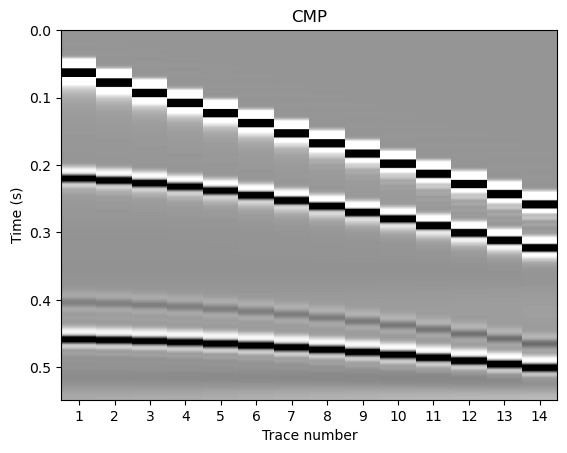

In [4]:
# separate data arrays for clarity and extract key info
dt = data['dt'] # timestep 
offsets = data['offsets']  #receivers/traces offsets/distance
cmp = data['CMP'] # data for each trace
nsamples = cmp.shape[0] # number of datapoints on each trace
noffsets = cmp.shape[1] # number of traces
times = np.arange(nsamples)*dt # time axis (proportional to depth)
seis.plot(cmp,noffsets, nsamples,dt)

**QUESTION: What seismic events can you see in this CMP gather? This is worth discussing with your peers.**
from top to bottom:
1) The direct wave
2) The reflection from the first interface
3) A multiple reflection from the first interface
4) The reflection from second interface

## Calculating NMO for our CMP Example

In [5]:
# known velocities, see later how these are obtained in reality
v1, t1 = 3800, 0.22
v2, t2 = 4800, 0.46

# create velocity profile for section. This will be used for the correction, different layers require different velocities to be corrected well
v_nmo = v1 + ((v2 - v1)/(t2 - t1))*(times - t1)  # equation for a straight line between two points. It is linear

In [6]:
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo)

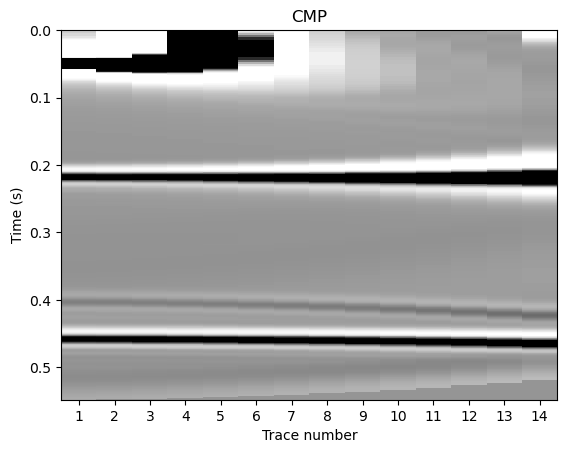

In [7]:
seis.plot(nmo, noffsets, nsamples,dt)

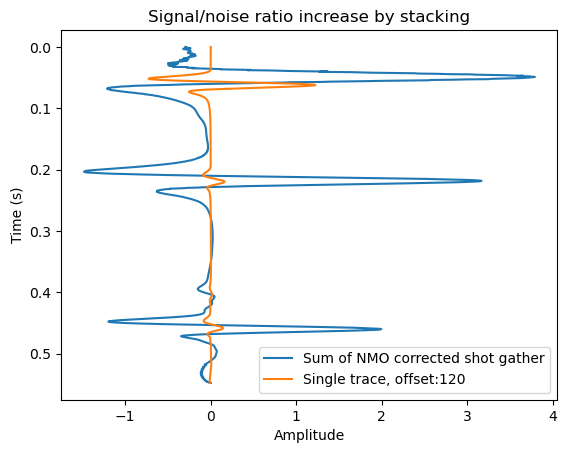

In [8]:
plt.plot(np.sum(nmo, axis = 1), times, label='Sum of NMO corrected shot gather')
plt.plot(cmp[:,0], times, label='Single trace, offset:' + str(offsets [0]))
plt.title("Signal/noise ratio increase by stacking")
plt.ylabel('Time (s)')
plt.xlabel('Amplitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Note that due to the use of a synthetic CMP there is a lack of noise, but we can still appreciate how the amplitudes can increase after stacking. Since noise is partially random it will not sum up like amplitudes, we say partially here because multiples for instance are also a source of noise in the data and they can be predicted! In seismic data processing we need to pick the velocities carefully so we only pick velocities for reflections, not multiples. IF this is done well the multiples will not be properly NMO corrected and therefore will not stack well (ie they will then have low amplitudes in stacked sections and be less of a problem).

##  2.3. Conducting a semblance analysis to determine NMO velocities

In reality, in order to find the correct NMO velocities for a full seismic trace we would need to do something called 'semblance analysis'. This involves computing and applying NMO corrections for a wide range of velocities from lower than expected for the study area to higher. A calculation is done to assess the success of the NMO correction. In our simple example we are going to stack the NMO corrected gathers and calculate the maximum amplitude. When we have computed the NMO velocities correctly for a particular reflector we will get the highest stacked amplitudes. Doing this for all reflections within the seismic trace produces a semblance plot from which a seismic data processor can, in most cases manually, select the correct velocities to use.

In [9]:
num = 10 # number of velocities to be tested (semblance plot resolution)
v_test = np.linspace(1000, 7000, num) # V testing range: [minimum velocity, maximum velocity, number of intervals/steps]

amp_store = seis.semblance(v_test, cmp, dt, offsets, times, verbose = True)

progress =  10.0 %
progress =  20.0 %
progress =  30.0 %
progress =  40.0 %
progress =  50.0 %
progress =  60.0 %
progress =  70.0 %
progress =  80.0 %
progress =  90.0 %
progress =  100.0 %


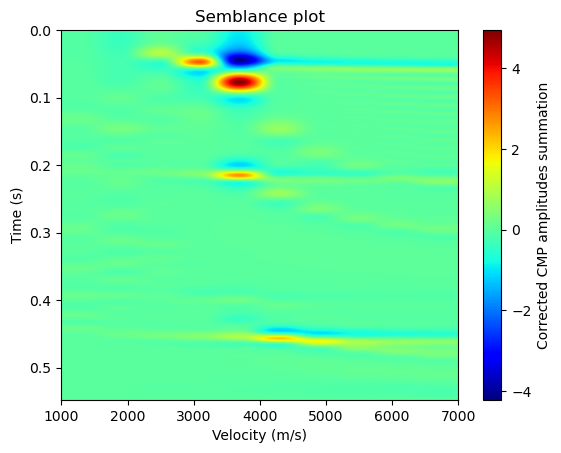

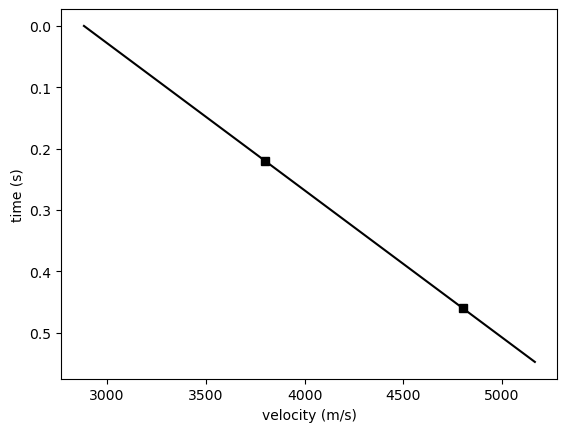

In [10]:
plt.imshow(np.swapaxes(amp_store,0,1), extent=[np.min(v_test), np.max(v_test),
                                            np.max(times), 0], aspect="auto",cmap='jet')
plt.title ('Semblance plot')
plt.colorbar(label = 'Corrected CMP amplitudes summation')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time (s)')
plt.show()
plt.plot(v_nmo, np.arange(nsamples)*dt, '-k')
plt.plot([v1, v2], [t1, t2], 'sk')
plt.xlabel('velocity (m/s)')
plt.ylabel('time (s)')
plt.gca().invert_yaxis()


## 2.4 Picking the correct NMO velocities

In this section we have developed a tool to allow you to manually pick the correct velocities for NMO analysis and apply them. If you are feeling adventurous feel free to write your own functions to carry out this process once you are done with the practical.
the observed velocity profile is just a simple piecewise linear function example, we could use more complex functions to fit between velocities. Feel free to implement an alternative fitting function if you have extra time! For some ideas see: https://reproducibility.org/RSF/book/jsg/avo/paper_html/node7.html

In [11]:
NMO_val = seis.click(amp_store, v_test, times) # right click to obtain data, escape to close window
#v_nmo = seis.vel_curve (amp_store, NMO_val, times) # create array containing velocity profile
#nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo) # carry out correction, you can use your own NMO function

QObject::moveToThread: Current thread (0x55de07539bb0) is not the object's thread (0x55de075cb250).
Cannot move to target thread (0x55de07539bb0)

QObject::moveToThread: Current thread (0x55de07539bb0) is not the object's thread (0x55de075cb250).
Cannot move to target thread (0x55de07539bb0)

QObject::moveToThread: Current thread (0x55de07539bb0) is not the object's thread (0x55de075cb250).
Cannot move to target thread (0x55de07539bb0)

QObject::moveToThread: Current thread (0x55de07539bb0) is not the object's thread (0x55de075cb250).
Cannot move to target thread (0x55de07539bb0)

QObject::moveToThread: Current thread (0x55de07539bb0) is not the object's thread (0x55de075cb250).
Cannot move to target thread (0x55de07539bb0)

QObject::moveToThread: Current thread (0x55de07539bb0) is not the object's thread (0x55de075cb250).
Cannot move to target thread (0x55de07539bb0)

QObject::moveToThread: Current thread (0x55de07539bb0) is not the object's thread (0x55de075cb250).
Cannot move to tar

In [ ]:
# show results
fig, ax = plt.subplots(1,2, figsize=(10, 5))

# cut-off outliers of data for better visualisation
vm = np.percentile(nmo, 95)
vmin, vmax = -vm, vm

ax[0].imshow(nmo, extent=[0.5, noffsets + 0.5, np.max(times), 0], 
          aspect="auto", cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title('NMO correction section')
ax[0].set_xlabel('Trace number')
ax[0].set_ylabel('Time (s)')

ax[1].plot(np.sum(nmo, axis = 1), times)
ax[1].set_title('Sum of NMO amplitudes')
ax[1].set_xlabel('Amplitude')
ax[1].invert_yaxis()

plt.show()

## 2.5 Conducting NMO corrections with a real CMP gather

In [Bonus](./Ex2_Bonus.ipynb) you will load a segy file of a real CMP gather and conduct your own NMO correction, courtesy of Rob allen from the VoilA project. You will quickly see that the reality of the situation is more complex then our examples above and there is a need to develop better methods to cope with real seismic data. 


# Refrences and Further Reading: 
<a id='refrences'></a>

- https://wiki.seg.org/wiki/Geophysical_tutorials.
- https://github.com/pinga-lab/nmo-tutorial/blob/master/step-by-step-nmo.ipynb